In [224]:
from collections import defaultdict
import requests
import time, os

import numpy as np
import pandas as pd

import json, urllib3, string
from bs4 import BeautifulSoup

import pickle
from sqlalchemy import create_engine

from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from IPython.display import Image
import matplotlib.pylab as pylab

import re

import gender_guesser.detector as gender

import statsmodels.api as sm
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split

## Load Pickle'd Modelling Data

In [225]:
with open('model_principals.pickle', 'rb') as f:
    model_principals = pickle.load(f)

len(model_principals[]

,imdbid,title,id,year,rating,imdbid_tt,tconst,directors,writers,production companies,...,1980,1990,2000,2010,2020,writer_female_flag,producer_female_flag,director_female_flag,Ex-US and Top Prod Comp,has top prod comp
2039,0103030,Tacones Lejanos,710,1991,3,tt0103030,tt0103030,nm0000264,nm0000264,"Canal+,CiBy 2000,El Deseo",...,0,1,0,0,0,No women,0,No women,1.0,1.0
3718,0384806,"Amityville Horror, The",4688,2005,3,tt0384806,tt0384806,nm1497918,"nm0466925,nm0030663,nm0827839,nm0527567,nm0527582","Metro-Goldwyn-Mayer (MGM),Dimension Films,Plat...",...,0,0,1,0,0,Has 1 woman,0,No women,0.0,1.0
420,0038762,My Darling Clementine,3783,1946,1,tt0038762,tt0038762,nm0000406,"nm0257143,nm0588003,nm0375500,nm0482193",Twentieth Century Fox,...,0,0,0,0,0,No women,0,No women,0.0,1.0
2234,0109686,Dumb &amp; Dumber,890,1994,2,tt0109686,tt0109686,"nm0268380,nm0125803","nm0268380,nm0947395,nm0125803",New Line Cinema,...,0,1,0,0,0,No women,No women,No women,0.0,1.0
6366,2369396,Bounty Killer,5097,2013,3,tt2369396,tt2369396,nm3026907,"nm2611629,nm1538954,nm3026907","Just Chorizo Productions,Kickstart Productions",...,0,0,0,1,0,No women,No women,No women,0.0,0.0


In [238]:
# nontest, test = train_test_split(model_principals, test_size=.2, random_state=10)
nontest, test = train_test_split(model_principals[model_principals['decade']>=1990], test_size=.2, random_state=10)
train, val = train_test_split(nontest, test_size = .25, random_state = 42)

features = ['writer_f_percent', 'director_f_percent', 'producer_f_count',
            'editor_f_count', 'cast_f_count', 'has top prod comp', 'Ex-US and Top Prod Comp',
#             1900,1910,1920,1930,1940,1950,
#             1960,1970,
            1980,1990,
            2000,2010,2020]

target = 'bechdel pass'

print(len(train))

3426


In [239]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

## K Nearest Neighbors

In [240]:
knn = KNeighborsClassifier()
knn_grid=GridSearchCV(estimator = knn,param_grid = {'n_neighbors':range(1,11)},scoring='accuracy')
knn_grid.fit(train[features], train[target])
knn_grid.score(val[features],val[target])

0.6348511383537653

In [241]:
clf.get_params()['estimator__n_neighbors']

5

## Random Forests

In [242]:
randomforest = RandomForestClassifier(n_estimators=100)
randomforest.fit(train[features], train[target])
randomforest.score(val[features],val[target])

0.6567425569176882

## SVC

In [243]:
linearsvc = LinearSVC()
linearsvc.fit(train[features], train[target])
linearsvc.score(val[features],val[target])
linearsvc.score(test[features],test[target])

0.6777583187390543

## Logistic Regression

In [244]:
from sklearn.linear_model import LogisticRegression

lm_1 = LogisticRegression(solver='newton-cg',  
                          C=100000)  # No regularization

lm_1.fit(train[features], train[target])

print('intercept: ', round(lm_1.intercept_[0], 4))
val_score = lm_1.score(val[features], val[target])
print('Training score:',lm_1.score(train[features], train[target]))
print('Validation score:',val_score)
lm_1.coef_[0]

intercept:  -0.8667
Training score: 0.6625802685347344
Validation score: 0.6865148861646234


array([ 1.76266217,  0.23168374,  0.18902677,  0.3445404 ,  1.52459858,
       -0.26631191,  0.10048602,  0.        , -0.48658142, -0.39107489,
       -0.23890266,  0.24981821])

In [245]:
test_score = lm_1.score(test[features], test[target])
print('Logistic test score:',test_score)


Logistic test score: 0.6777583187390543


ROC Curve Plotting

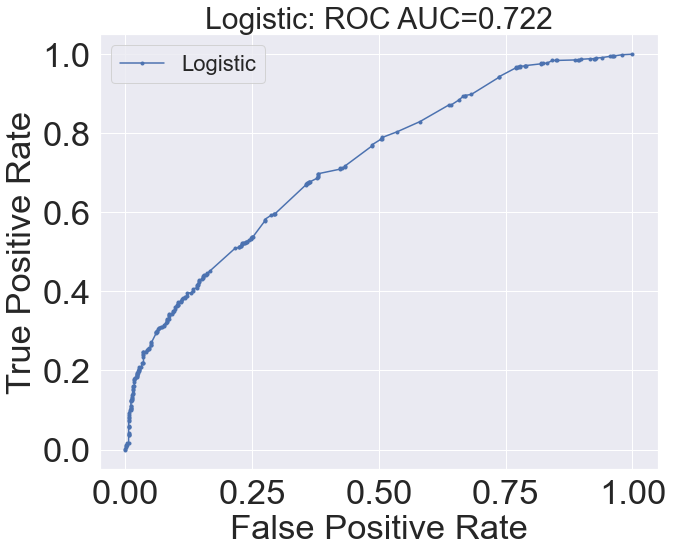

In [246]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

params = {'figure.figsize': (10, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',}

sns.set(font_scale=2)

pylab.rcParams.update(params)


lr_probs = lm_1.predict_proba(test[features])

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(test[target], lr_probs)
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(test[target], lr_probs)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
title = 'Logistic: ROC AUC=%.3f' % (lr_auc)
plt.title(title, size = 30);
# show the plot
plt.show()

Recall is [0.26351351 0.94126074]
Precision is [0.74050633 0.66768293]


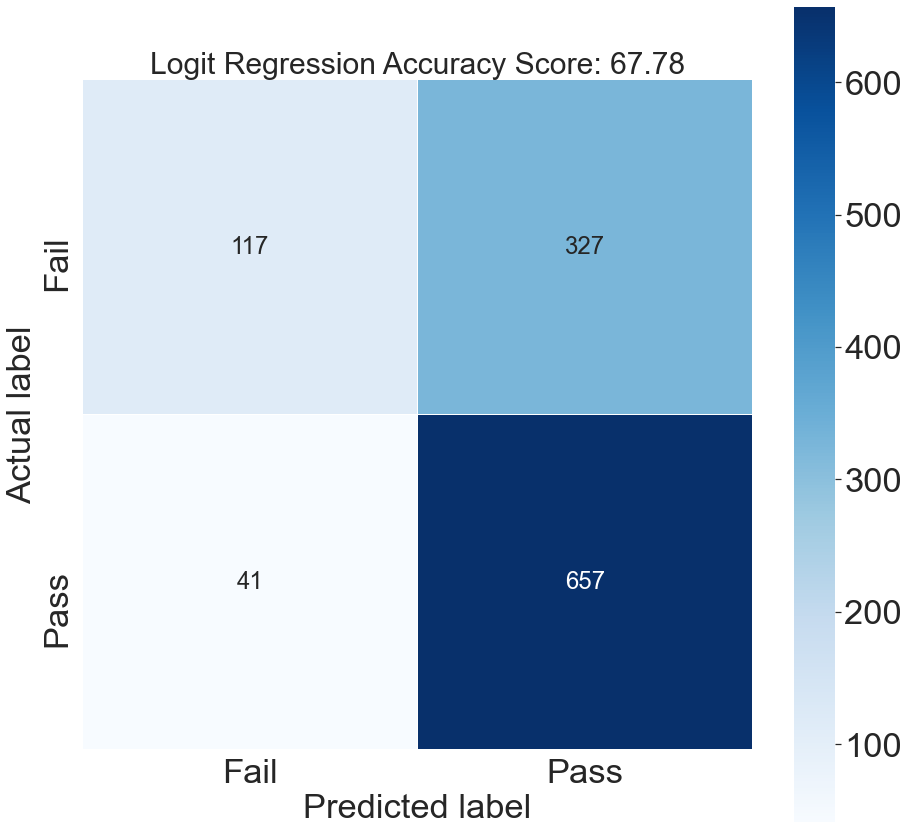

In [247]:
from sklearn import metrics
from sklearn.metrics import recall_score
# Precision
from sklearn.metrics import precision_score
print("Recall is", recall_score(test[target], test_predicts, average=None))
print("Precision is", precision_score(test[target], test_predicts, average=None))

test_predicts = lm_1.predict(test[features])
cm = metrics.confusion_matrix(test[target], test_predicts)

plt.figure(figsize=(15,15))
g = sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Logit Regression Accuracy Score: %.2f' % (test_score*100)
# g.set(xticks=['Fail','Pass'],yticks=['Fail','Pass'])
g.set_xticklabels(labels=['Fail','Pass'])
g.set_yticklabels(labels=['Fail','Pass'])
plt.title(all_sample_title, size = 30);
plt.savefig("Confusion Matrix.svg", format="svg")

# Appendix - Extras

### Can opt to get the dubious column from getMovieByImbdId on Bechdel Test Movie List

In [80]:
# %%time

# dubious_data = []
# error_ids = []
# for row in bechdel_movies['imdbid']:
#     response = requests.get('http://bechdeltest.com/api/v1/getMovieByImdbId?imdbid='+str(row))
#     data = response.json()
#     if str(row) == data['imdbid']:
#         print('Match found with',str(row))
#         dubious_dict = {}
#         dubious_dict['imdbid'] = data['imdbid']
#         dubious_dict['dubious'] = data['dubious']
#         dubious_data.append(dubious_dict)
#     else:
#         print('Error with',str(row))
#         error_ids.append(str(row))
        
# print(error_ids)        
# pd.DataFrame(dubious_data)

### Query movies by ID using imdbpy library

In [25]:
from imdb import IMDb
from imdb.helpers import makeTextNotes

In [26]:
%%time
# create an instance of the IMDb class
ia = IMDb()

Wall time: 287 ms


In [27]:
ia.get_person_infoset()

['awards',
 'biography',
 'filmography',
 'genres links',
 'keywords links',
 'main',
 'news',
 'official sites',
 'other works',
 'publicity']

In [ ]:
# movie_info = ['cast', 'genres', 'year', 'producers', 'editors', 'editorial department', \
#  'production managers', 'assistant directors', 'script department', 'writer', \
#  'director', 'production companies']

In [4]:
name_id = 'nm0510024'
url = "https://www.imdb.com/name/"+name_id+"/bio?ref_=nm_ov_bio_sm"
# try:
response = requests.get(url)
if response.status_code != 200:
    print('error: page not found with', name_id)
    pronoun_mode = 'error'
else:
    soup = BeautifulSoup(response.text)
    div = soup.find('div',class_='soda odd')
    print(div)
    if type(div) == type(None):
        print('bio not found with',name_id)
        pronoun_mode = "error"
    else:
        bio = div.text.strip()
        patt = re.compile(r"(he|his|him|she|her|it|its|they|their|them) ",re.IGNORECASE)
        matches = patt.findall(bio)
        if matches == []:
            print('pronouns not found in bio for',name_id)
            pronoun_mode = 'error - no pronouns'
        else:
            matches_series = pd.Series(matches).str.lower().value_counts().reset_index()
            matches_series.loc[matches_series['index'].str.contains('he|his|him'),'bio gender'] = 'male'
            matches_series.loc[matches_series['index'].str.contains('she|her'),'bio gender'] = 'female'
            matches_series.loc[matches_series['index'].str.contains('it|its|they|their|them'),'bio gender'] = 'nb'
            pronoun_mode = matches_series['bio gender'].value_counts().index[0]
# except Exception as e:
#     print(e)
#     pronoun_mode = 'error'
pronoun_mode

<div class="soda odd">
          Adopted wife's daughter, Pat.<br/>
</div>
pronouns not found in bio for nm0510024


'error - no pronouns'

In [106]:
patt = re.compile(r"(he|she|it|they|his|her|their) ",re.IGNORECASE)
print(patt.findall(words))
# print(list(pd.Series(patt.findall(words)).str.lower().value_counts().index))

['he', 'he', 'His', 'he', 'he', 'he', 'he', 'he', 'he']


In [39]:
movie = ia.get_movie('0133093')
plot=movie['plot'][0]
plot

'When a beautiful stranger leads computer hacker Neo to a forbidding underworld, he discovers the shocking truth--the life he knows is the elaborate deception of an evil cyber-intelligence.'

In [29]:
print(movie['directors'])
print(movie['director'])


[<Person id:0905154[http] name:_Lana Wachowski_>, <Person id:0905152[http] name:_Lilly Wachowski_>]
[<Person id:0905154[http] name:_Lana Wachowski_>, <Person id:0905152[http] name:_Lilly Wachowski_>]


# Buggy code

### Pickle Imported Data

In [136]:
# for item in datasets_zip[:3]:
#     to_pickle =item[1] + '.pickle'
#     print(to_pickle)
#     with open(to_pickle, 'wb') as f:
#         pickle.dump(item[0], f, pickle.HIGHEST_PROTOCOL)

bechdel_movies.pickle
title_crew.pickle
title_basics.pickle


In [137]:
# for item in datasets_zip[3:]:
#     to_pickle =item[1] + '.pickle'
#     print(to_pickle)
#     with open(to_pickle, 'wb') as f:
#         pickle.dump(item[0], f, pickle.HIGHEST_PROTOCOL)

title_principals.pickle
title_akas.pickle
name_basics.pickle


### Load Pickle'd Data when returning to this notebook

In [139]:
db_dict = {}

In [140]:
# for item in datasets_zip[:3]:
#     from_pickle =item[1] + '.pickle'
#     print(from_pickle)
#     with open(from_pickle, 'rb') as f:
#         db_dict[item[1]] = pickle.load(f)

bechdel_movies.pickle
title_crew.pickle
title_basics.pickle


In [157]:
# for item in datasets_zip[3:]:
#     from_pickle =item[1] + '.pickle'
#     print(from_pickle)
#     with open(from_pickle, 'rb') as f:
#         db_dict[item[1]] = pickle.load(f)

# Appendix - Old Code

In [ ]:
# engine = create_engine('postgresql://postgres:warroo:localhost@localhost:5432/tennis')

# title_principals = pd.read_csv('title.principals.tsv',sep='\t')

# # I'm choosing to name this table "aus_men"
# title_principals.to_sql('title_principals', engine, index=False)